In [2]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
import kerastuner as kt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM

from scipy.stats import probplot
from scipy.stats import normaltest

from joblib import dump, load

from scipy import signal

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

Using TensorFlow backend.


In [3]:
def fft_from_vib(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
    amps /= 0.01
#     lin_amps = lin_log_interp(amps)
    return amps


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [4]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [5]:
samples_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')
# nominal_samples = np.array([64.,65.,70.,71.,74.,75.,79.,80.])
# anomalous_samples = np.array([92.,95.,101.,102.,103.,104.,105.,110.])
# healthy_args = np.argwhere([samples_train == nominal_samples[i] for i in range(nominal_samples.shape[0])])[:,1]
# unhealthy_args = np.argwhere([samples_train == anomalous_samples[i] for i in range(anomalous_samples.shape[0])])[:,1]

In [6]:
first_unhealthy = 156

In [7]:
sfm_args = np.argwhere((samples_train[:,0] == 250/300)).flatten()
ipt_args = np.argwhere((samples_train[:,1] == 0.002/0.003)).flatten()
doe_args = sfm_args[np.argwhere([sfm_args == ipt_args[i] for i in range(ipt_args.shape[0])])[:,1]]

In [8]:
# samples_train[doe_args,:]

In [9]:
healthy_args = doe_args[doe_args < first_unhealthy]
unhealthy_args = doe_args[doe_args > first_unhealthy]

In [46]:
healthy_args = healthy_args[healthy_args != 112]

In [47]:
max_fft = 128

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train_orig = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test_orig = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train_orig = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test_orig = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

print(X_train.shape)

first_good_train = np.argwhere(Y_train_orig[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test_orig[:,0] == 0).flatten()[0]

X_train = fft_from_vib(X_train_orig[:,:-1])[:,1:]
X_test = fft_from_vib(X_test_orig[:,:-1])[:,1:]



X_train_healthy = X_train[healthy_args,:max_fft]
X_valid_healthy = X_test[first_good_test:,:max_fft]
X_train_unhealthy = X_train[unhealthy_args,:max_fft]
X_valid_unhealthy = X_test[:first_good_test,:max_fft]



Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:max_fft]
Y_train = XY_train[:,-1]

X_valid = XY_valid[:,:max_fft]
Y_valid = XY_valid[:,-1]


X = []

X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']


(99, 128)


/home/dnewman/.local/lib/python3.6/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 4096 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


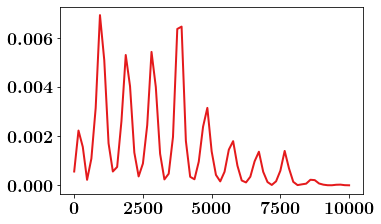

In [58]:
freqs,amps = signal.welch(X_train[35,:], fs=20e3, nperseg=4096, scaling='spectrum')
plt.plot(freqs[:128],amps[:128])

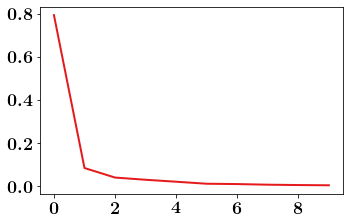

In [113]:
pca = PCA()
pca.fit(X_train_healthy)
plt.plot(pca.explained_variance_ratio_[:10])

In [115]:

fftPoints = 2048

estimators = [('reduce_dim', PCA(n_components=4)), ('gmm', GaussianMixture(n_components=1))]

pipe = Pipeline(estimators)
pipe.fit(X_train_healthy,Y_train_healthy)

scores_gmm = []

scores_gmm = [np.zeros_like(X[i]) for i in range(len(X))]

for i in range(len(columns)):
    scores_gmm[i] = pipe.score_samples(X[i][:,:fftPoints])
    print(np.mean(scores_gmm[i]),np.std(scores_gmm[i]))

0.14298314964925327 1.698293929974702
-82.04839419902677 300.72394735093934
-2.8681001721937203 8.833291539453487
-2.011304814651967 5.385691259536526


In [116]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

for i in range(2,128):

    estimators = [('reduce_dim', PCA(n_components=i)), ('gmm', KMeans(n_clusters=2))]
    # estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

    fftPoints = 2048

    pipe = Pipeline(estimators)
    pipe.fit(X_train,Y_train)

    Y_valid_pred = pipe.predict(X_valid)
    conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
    accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
    print(accuracy_valid)


0.5099337748344371
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.4900662251655629
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.4900662251655629
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.4900662251655629
0.4900662251655629
0.4900662251655629
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.5099337748344371
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.5099337748344371
0.4900662251655629
0.5099337748344371
0.5099337748344371
0.5099337748344371
0.4900662251

ValueError: n_components=99 must be between 0 and min(n_samples, n_features)=98 with svd_solver='full'

In [117]:
def normalize_scores(scores,log_prob=False):

    flat = np.array([])
    for i in range(len(scores)):
        flat = np.append(flat,scores[i])
    
    max_val = np.amax(flat)
    
    if log_prob:
        scores = [np.log(np.abs(scores[i] - 1.1 * max_val)) for i in range(len(scores))]
    

    norm_mean = np.mean(scores[0])
    norm_std = np.std(scores[0])
    
    scores = [(scores[i] - norm_mean) / norm_std for i in range(len(scores))]
    
    [print(normaltest(scores[i])) for i in range(len(scores))]
    [print(np.std(scores[i]), np.mean(scores[i])) for i in range(len(scores))]
    
    return scores

In [118]:
test = np.array([])
for i in range(len(scores_gmm)):
    test = np.append(test,scores_gmm[i])
print(test.shape)
# [np.append(test,scores_gmm[i]) for i in range(len(scores_gmm))]

(249,)


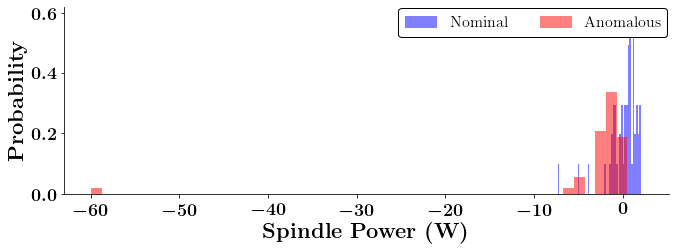

In [119]:
num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(scores_gmm[0], 50, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(scores_gmm[2], 50, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Spindle Power (W)}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('figures/Spindle_Load_Anomalous_Compare.png',transparent=True)     
plt.show()


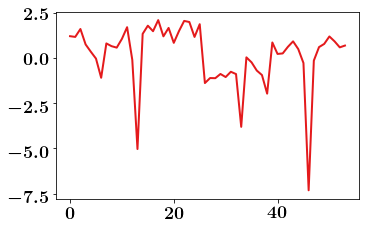

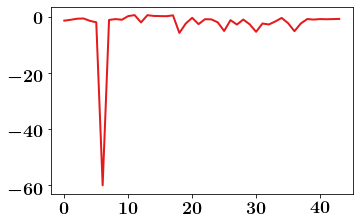

In [121]:
plt.plot(scores_gmm[0])
plt.show()
plt.plot(scores_gmm[2])
plt.show()

NormaltestResult(statistic=3.2711325915177767, pvalue=0.194842001851955)
NormaltestResult(statistic=47.354351684180855, pvalue=5.213545699637969e-11)
NormaltestResult(statistic=48.610279110551105, pvalue=2.782351595122522e-11)
NormaltestResult(statistic=41.50402592940165, pvalue=9.716621397903008e-10)
1.0 -7.600658785483566e-17
2.148891478433604 1.7715581902631505
0.732954407113168 1.0886423797255649
0.7369575244714021 0.9239054100035158


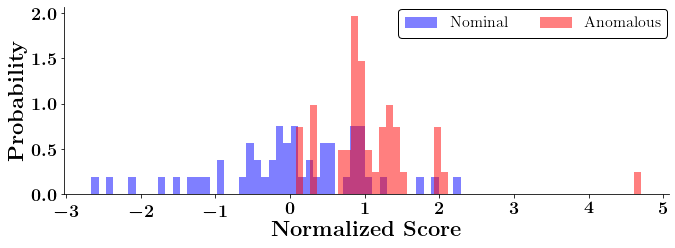

In [126]:
norm_scores_gmm = normalize_scores(scores_gmm,log_prob=True)

num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_scores_gmm[0], 50, density=True, facecolor='b', alpha=0.50,label='Nominal')
n, bins, patches = plt.hist(norm_scores_gmm[2], 50, density=True, facecolor='r', alpha=0.50,label='Anomalous')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'\textbf{Normalized Score}')
plt.ylabel(r'\textbf{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
plt.grid(False)
plt.savefig('figures/Spindle_Load_Anomalous_Compare.png',transparent=True)     
plt.show()



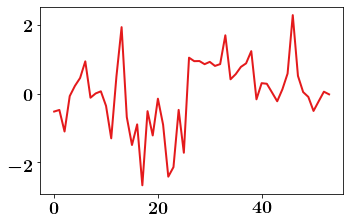

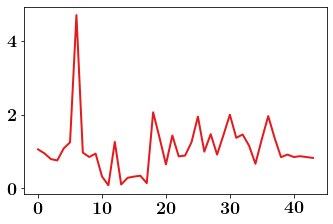

In [125]:
plt.plot(norm_scores_gmm[0])
plt.show()

plt.plot(norm_scores_gmm[2])
plt.show()

In [67]:
print(pipe['gmm'].covariances_.size)
print(pipe['gmm'].weights_.size)
print(pipe['gmm'].means_.size)

# dump(pipe, 'data/pca_gmm.joblib') 

49
1
7


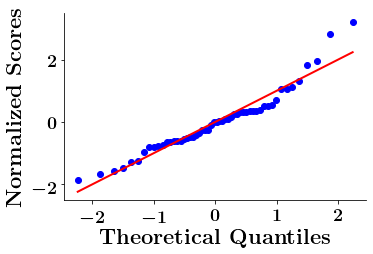

No handles with labels found to put in legend.


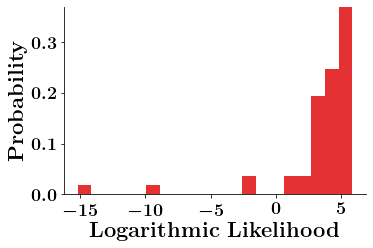

In [68]:
genplt.plot_normaltest(norm_scores_gmm[0],
                'Theoretical Quantiles',
                'Normalized Scores',
                'PCA-GMM_NormalTest')

genplt.plot_histogram(scores_gmm[0],[''],
               'Logarithmic Likelihood',
               'Probability',
               'PCA-GMM_Histogram_Train_Healthy',
               template='publication')

In [69]:
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_vanilla_ae(hp):
    encoder = Sequential()
    encoder.add(Input(shape=max_fft))
    encoder.add(Flatten())


    for i in range(hp.Int('hidden_layers', 2, 5, step=1)):
        encoder.add(Dense(hp.Int('hidden_nodes' + str(i), 8, 256, step=8), activation='relu'))    
        encoder.add(BatchNormalization())
        
    hidden_layer_num = hp.get('hidden_layers')
    
    for i in range(hidden_layer_num-1,-1,-1):
        this_hidden_nodes = hp.get('hidden_nodes' + str(i))
        encoder.add(Dense(this_hidden_nodes, activation='relu')) 
        encoder.add(BatchNormalization())
    
    encoder.add(Dense(np.prod(max_fft), activation='sigmoid', ))
    encoder.add(Reshape(list([max_fft])))
    encoder.compile(loss='mean_squared_error', 
                      optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),)

    return encoder


In [96]:
tuner = kt.Hyperband(
    create_vanilla_ae,
    objective='val_loss',
    max_epochs=30,
    hyperband_iterations=2,
    directory='ae_fft_250sfm_002ipt',
    project_name='ae_fft_250sfm_002ipt')

tuner.search(X[0][:,:fftPoints],X[0][:,:fftPoints],
             validation_split=0.2,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project ae_fft_250sfm_002ipt/ae_fft_250sfm_002ipt/oracle.json
INFO:tensorflow:Reloading Tuner from ae_fft_250sfm_002ipt/ae_fft_250sfm_002ipt/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [97]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
loss = model.fit(
            X[0][:,:fftPoints],X[0][:,:fftPoints],
            validation_split=0.2,
            epochs=30,
            verbose=1)

Train on 43 samples, validate on 11 samples
Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 0.002 - 1s 12ms/sample - loss: 0.0024 - val_loss: 0.0034
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.002 - 0s 303us/sample - loss: 0.0024 - val_loss: 0.0033
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.001 - 0s 288us/sample - loss: 0.0021 - val_loss: 0.0032
Epoch 4/30
43/43 [==============================] - ETA: 0s - loss: 0.002 - 0s 326us/sample - loss: 0.0019 - val_loss: 0.0032
Epoch 5/30
43/43 [==============================] - ETA: 0s - loss: 0.002 - 0s 341us/sample - loss: 0.0020 - val_loss: 0.0031
Epoch 6/30
43/43 [==============================] - ETA: 0s - loss: 0.001 - 0s 376us/sample - loss: 0.0022 - val_loss: 0.0032
Epoch 7/30
43/43 [==============================] - ETA: 0s - loss: 0.002 - 0s 292us/sample - loss: 0.0019 - val_loss: 0.0032
Epoch 8/30
43/43 [==============================] - ETA: 0s - loss: 0.002 -

In [99]:
X_vanilla_ae = np.zeros_like(X)
mse_vanilla_ae = np.zeros_like(scores_gmm)

X_vanilla_ae = [np.array([]) for i in range(len(X))]
mse_vanilla_ae = [np.array([]) for i in range(len(X))]

In [100]:
for i in range(len(columns)):
    X_vanilla_ae[i] = model.predict(X[i][:,:fftPoints])
    mse_vanilla_ae[i] = keras.metrics.mean_squared_error(X_vanilla_ae[i],X[i][:,:fftPoints])

norm_vanilla_ae = normalize_scores(mse_vanilla_ae,log_prob=True)



NormaltestResult(statistic=57.968133384809235, pvalue=2.584519256829795e-13)
NormaltestResult(statistic=109.52317059899886, pvalue=1.649474796939637e-24)
NormaltestResult(statistic=44.86122814283231, pvalue=1.813460427655604e-10)
NormaltestResult(statistic=139.33698676740454, pvalue=5.538061330169482e-31)
1.0 3.101649e-06
111.10868 -37.791748
1.6942501 -1.4224674
166.39319 -35.24052


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                6192      
_________________________________________________________________
batch_normalization (BatchNo (None, 48)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 144)               7056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 144)               576       
_________________________________________________________________
dense_2 (Dense)              (None, 144)               20880     
_________________________________________________________________
batch_normalization_2 (Batch (None, 144)               5

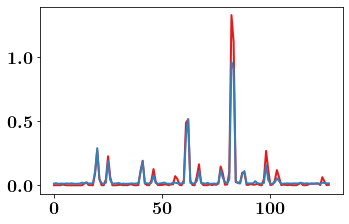

In [101]:
print(model.summary())

plt.plot(X[0][0,:fftPoints])
plt.plot(X_vanilla_ae[0][0,:])
plt.show()


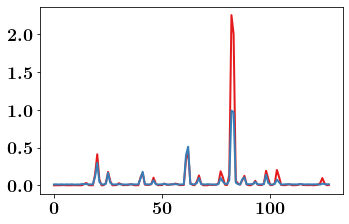

array([82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82,
       82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82,
       82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82,
       82, 82, 82])

In [108]:
plt.plot(X[0][13,:fftPoints])
plt.plot(X_vanilla_ae[0][13,:])
plt.show()
np.argmax(X_vanilla_ae[0],axis=1)

In [107]:
np.argmin(norm_vanilla_ae[0])

13

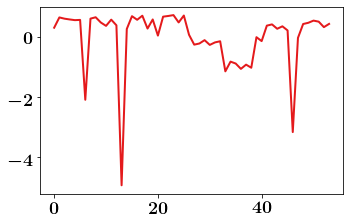

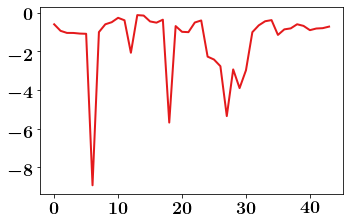

In [106]:
plt.plot(norm_vanilla_ae[0])
plt.show()

plt.plot(norm_vanilla_ae[2])
plt.show()

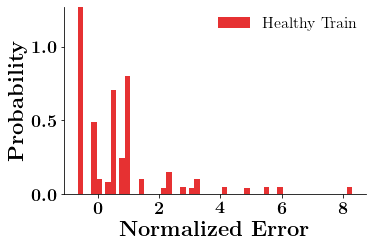

In [77]:

responses = [norm_vanilla_ae[0],
                       norm_vanilla_ae[2]]
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'AE_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


In [78]:
import numpy as np

from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live
    
    
def create_autoencoder(hp):
    inputs = Input(shape=(max_fft,1))
    x = inputs
    for i in range(hp.Int('filters', 2, 5, step=1)):
            x = Conv1D(filters=hp.Int('filters_' + str(i), 4, 64, step=4), 
                               kernel_size=hp.Int('kernels_' + str(i), 3, 19, step=2), 
                               strides=1, 
                               activation='relu', 
                               padding='same',
                               dilation_rate=1)(x)
            
            x = Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1))(x)
            x = MaxPooling1D(2)(x)
            
    filter_num = hp.get('filters')
    
    for i in range(filter_num-1,-1,-1):
        this_filter = hp.get('filters_' + str(i))
        this_kernel = hp.get('kernels_' + str(i))
        x = Conv1D(filters=this_filter, 
                           kernel_size=this_kernel, 
                           strides=1, 
                           activation='relu', 
                           padding='same',
                           dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = UpSampling1D(2)(x)

    x = Conv1D(1, 3, 1, activation='sigmoid', padding='same')(x)
            
    model = Model(
                inputs=[inputs],
                outputs=[x])
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='mean_squared_error')

    return model
    

In [79]:
tuner = kt.Hyperband(
    create_autoencoder,
    objective='val_loss',
    max_epochs=30,
    hyperband_iterations=2,
    directory='cnn-ae_fft',
    project_name='cnn-ae_fft_250sfm_002ipt')

tuner.search(X[0][:,:fftPoints][...,np.newaxis],X[0][:,:fftPoints][...,np.newaxis],
             validation_split=0.2,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project cnn-ae_fft/cnn-ae_fft_250sfm_002ipt/oracle.json
INFO:tensorflow:Reloading Tuner from cnn-ae_fft/cnn-ae_fft_250sfm_002ipt/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [80]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
loss = model.fit(
            X[0][:,:fftPoints][...,np.newaxis],X[0][:,:fftPoints][...,np.newaxis],
            validation_split=0.2,
            epochs=30,
            verbose=1)

Train on 43 samples, validate on 11 samples
Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 0.026 - 2s 51ms/sample - loss: 0.0279 - val_loss: 0.0190
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.022 - 0s 450us/sample - loss: 0.0219 - val_loss: 0.0209
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.019 - 0s 505us/sample - loss: 0.0196 - val_loss: 0.0218
Epoch 4/30
43/43 [==============================] - ETA: 0s - loss: 0.015 - 0s 547us/sample - loss: 0.0155 - val_loss: 0.0219
Epoch 5/30
43/43 [==============================] - ETA: 0s - loss: 0.014 - 0s 498us/sample - loss: 0.0157 - val_loss: 0.0220
Epoch 6/30
43/43 [==============================] - ETA: 0s - loss: 0.012 - 0s 459us/sample - loss: 0.0139 - val_loss: 0.0220
Epoch 7/30
43/43 [==============================] - ETA: 0s - loss: 0.014 - 0s 545us/sample - loss: 0.0133 - val_loss: 0.0220
Epoch 8/30
43/43 [==============================] - ETA: 0s - loss: 0.012 -

In [81]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 8)            96        
_________________________________________________________________
dropout (Dropout)            (None, 128, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 20)            2740      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 20)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 20)            0     

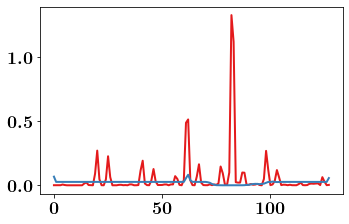

NormaltestResult(statistic=32.110416530516254, pvalue=1.0649069087326006e-07)
NormaltestResult(statistic=95.98742793679574, pvalue=1.4341509253994437e-21)
NormaltestResult(statistic=28.707646764080373, pvalue=5.837322810765417e-07)
NormaltestResult(statistic=127.9519995226685, pvalue=1.6427683589890053e-28)
1.0 6.2364116e-08
20.860832 6.9058084
0.946644 0.33238724
16.665838 4.04559


In [82]:
X_conv_ae = [np.array([]) for i in range(len(X))]
mse_conv_ae = [np.array([]) for i in range(len(X))]

for i in range(len(columns)):
    X_conv_ae[i] = np.squeeze(model.predict(X[i][...,np.newaxis]))
    mse_conv_ae[i] = keras.metrics.mean_squared_error(X_conv_ae[i],X[i][:,:fftPoints])

plt.plot(X[0][0,:fftPoints])
plt.plot(X_conv_ae[0][0,:])
plt.show()

norm_conv_ae = normalize_scores(mse_conv_ae)

In [61]:
if os.path.isfile('data/CNN-AE.h5'):
    from tensorflow.keras.models import load_model
    model = load_model('data/CNN-AE.h5')
    print(model.summary())
else:
    filters=[8,16,32]
    kernels = [3,3,3]
    strides=[1,1,1,1,1,1]
    dilation_rates=[1,1,1,1,1,1]
    input_shape = [2048,1]

    param_dict = {
        "filters":filters,
        "kernels":kernels,
        "strides":strides,
        "dilation_rates":dilation_rates,
        "input_shape":input_shape,
    }

    model,encoder,decoder = create_autoencoder(param_dict)

    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X[...,0,np.newaxis],X[...,0,np.newaxis],
                        epochs=30,batch_size=16,
                        validation_split=0.2,verbose=1,
    #                     validation_data=[X_healthy_test[...,np.newaxis],X_healthy_test[...,np.newaxis]]
                       )
    
#     model.save('data/CNN-AE.h5',save_format='tf')


# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# open(os.path.join('data', 'CNN-AE.tflite',),
#      "wb").write(tflite_model)



Train on 124 samples, validate on 32 samples
Epoch 1/30
124/124 [==============================] - 4s 33ms/sample - loss: 0.0315 - val_loss: 0.0612
Epoch 2/30
124/124 [==============================] - 0s 2ms/sample - loss: 0.0195 - val_loss: 0.0616
Epoch 3/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0139 - val_loss: 0.0619
Epoch 4/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0109 - val_loss: 0.0616
Epoch 5/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0091 - val_loss: 0.0606
Epoch 6/30
124/124 [==============================] - 0s 2ms/sample - loss: 0.0078 - val_loss: 0.0598
Epoch 7/30
124/124 [==============================] - 0s 2ms/sample - loss: 0.0071 - val_loss: 0.0590
Epoch 8/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0065 - val_loss: 0.0587
Epoch 9/30
124/124 [==============================] - 0s 1ms/sample - loss: 0.0061 - val_loss: 0.0586
Epoch 10/30
124/124 [===============

In [62]:

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='data/CNN-AE.tflite')

def tflite_inference(data,tflite_interpreter):
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Test model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = data[:,np.newaxis,:,np.newaxis].astype(np.float32)
    
    output_shape = output_details[0]['shape']
    num_samples = input_data.shape[0]

    all_outputs = np.zeros((num_samples,output_shape[1],output_shape[2]))

    for i in range(num_samples):

        interpreter.set_tensor(input_details[0]['index'], input_data[i,...])
        interpreter.invoke()

        # The function `get_tensor()` returns a copy of the tensor data.
        # Use `tensor()` in order to get a pointer to the tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        

        all_outputs[i,...] = output_data
    
    return all_outputs


ValueError: Could not open 'data/CNN-AE.tflite'.

In [63]:
X_conv_ae_lite = np.zeros_like(X)
mse_conv_ae_lite = np.zeros_like(scores_gmm)

for i in range(len(columns)):
    X_conv_ae_lite[...,i] = np.squeeze(tflite_inference(X[...,i],interpreter))
    mse_conv_ae_lite[:,i] = keras.metrics.mean_squared_error(X_conv_ae_lite[...,i],X[...,i])

norm_conv_ae_lite = normalize_scores(mse_conv_ae_lite)

NameError: name 'tflite_inference' is not defined

In [64]:
norm_conv_ae_lite.shape


NameError: name 'norm_conv_ae_lite' is not defined

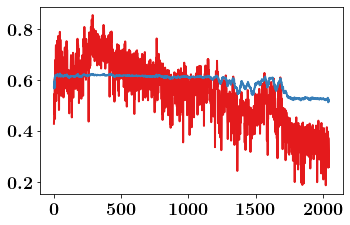

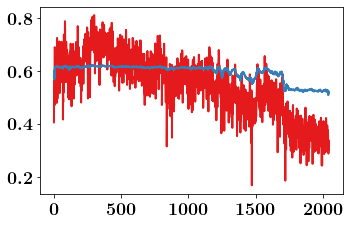

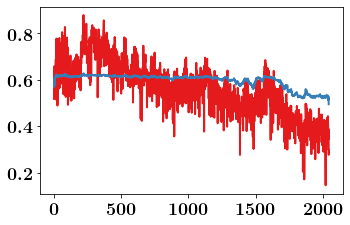

In [65]:
plt.plot(X[0,1:-1,0])
plt.plot(X_conv_ae[0,1:-2,0])
plt.show()


plt.plot(X[0,1:-1,1])
plt.plot(X_conv_ae[0,1:-2,1])
plt.show()


plt.plot(X[0,1:-1,2])
plt.plot(X_conv_ae[0,1:-2,2])
plt.show()


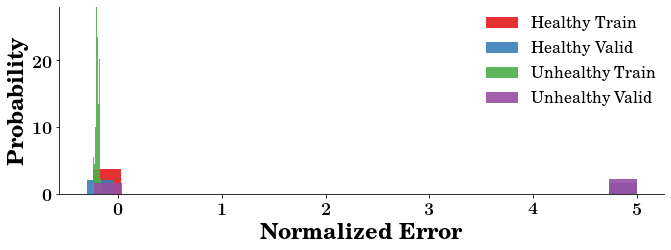

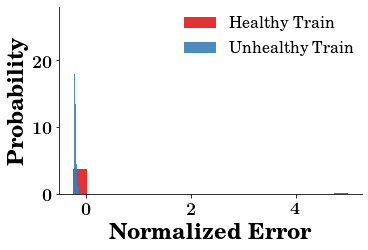

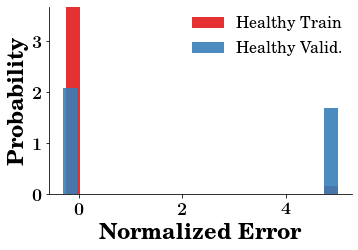

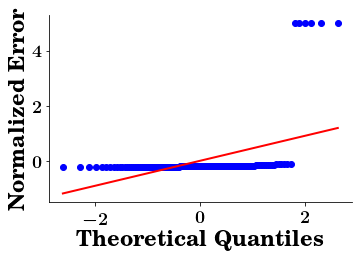

No handles with labels found to put in legend.


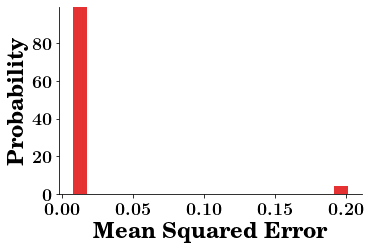

In [66]:
genplt.plot_histogram(norm_conv_ae,columns,
               'Normalized Error',
               'Probability',
               'CNN-AE_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae[:,0],
                       norm_conv_ae[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae[:,0],
                       norm_conv_ae[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_conv_ae[...,0],
                'Theoretical Quantiles',
                'Normalized Error',
                'CNN-AE_NormalTest')

genplt.plot_histogram(mse_conv_ae[...,0],[''],
               'Mean Squared Error',
               'Probability',
               'CNN-AE_Histogram_Train_Healthy',
               template='publication')

In [67]:
genplt.plot_histogram(norm_conv_ae_lite,columns,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Histogram_All',
               template='wide',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae_lite[:,0],
                       norm_conv_ae_lite[:,2]))
labels = ['Healthy Train','Unhealthy Train']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Historgram_Healthy_Unhealthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)

responses = np.vstack((norm_conv_ae_lite[:,0],
                       norm_conv_ae_lite[:,1]))
labels = ['Healthy Train','Healthy Valid.']

genplt.plot_histogram(responses,labels,
               'Normalized Error',
               'Probability',
               'CNN-AE-Lite_Historgram_Healthy_Train_Valid',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               num_col=1)


genplt.plot_normaltest(norm_conv_ae_lite[...,0],
                'Theoretical Quantiles',
                'Normalized Error',
                'CNN-AE-Lite_NormalTest')

genplt.plot_histogram(mse_conv_ae_lite[...,0],[''],
               'Mean Squared Error',
               'Probability',
               'CNN-AE-Lite_Histogram_Train_Healthy',
               template='publication')

NameError: name 'norm_conv_ae_lite' is not defined

In [68]:
import tflite_runtime.interpreter as tflite

In [51]:
a = np.array([1,2,3,4,5,6])

In [52]:
a.shape

(6,)

In [54]:
np.atleast_2d(a).shape

(1, 6)